[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving coursera_courses.csv to coursera_courses.csv
=== Sample cleaned descriptions ===
0    pursue better security job opportunities prove...
1    develop proficiency required design develop co...
2    affordable abundant reliable energy fundamenta...
3    heard phrase correlation equal causation equal...
4    adhd challenges come whether person affected a...
Name: clean_description, dtype: object 

=== Sample generated summaries ===
0    The SSCP Professional Training Certificate sho...
1    By the end, you will be proficient in leveragi...
2    Climate change, environmental sustainability, ...
3    Over a period of 5 weeks, you will learn how c...
4    Since in two thirds of cases this disorder is ...
Name: summary_generated, dtype: object 

Precision: 0.037, Recall: 1.000, F1 Score: 0.072

=== TF-IDF Feature Matrix (first 5 rows) ===
     course      data   de     learn  learning   project  skills  \
0  0.953398  0.131075  0.0  0.096544  0.096221  0.199978     0.0   
1  0.000000  0

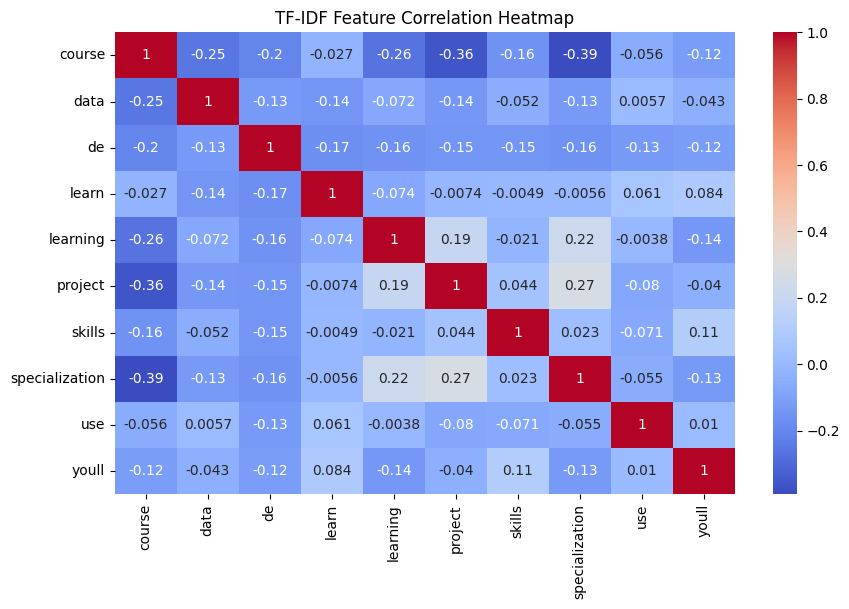



Best F1 score: 0.101 with 5 summary sentences


Project By : 
 - Garv Rastogi
 - Kunal Arora
 - Kundan Kumar
 - Md Shahnawaz Alam


In [ ]:
#Project By:
#1.Garv Rastogi
#2.Kunal Arora
#3.KUNDAN KUMAR
#4.Md Shahnawaz Alam


# Install necessary packages (run once)
!pip install nltk seaborn scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import files

# Download NLTK data (run once)
nltk.download('punkt_tab')
nltk.download('stopwords')

# Upload CSV file (choose your file when prompted)
uploaded = files.upload()

# Load the dataset (replace with your actual filename if different)
df = pd.read_csv(next(iter(uploaded.keys())))

# 1. Preprocessing function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply cleaning to course descriptions
df['clean_description'] = df['course_description'].fillna('').apply(clean_text)

print("=== Sample cleaned descriptions ===")
print(df['clean_description'].head(), "\n")

# 2. TF-IDF Extractive Summarizer
def extract_summary(text, num_sentences=2):
    text = str(text)
    sentences = sent_tokenize(text, language='english')
    if len(sentences) <= num_sentences:
        return text
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)
    sentence_scores = tfidf_matrix.sum(axis=1).A1  # Sum of TF-IDF scores per sentence
    ranked_indices = np.argsort(sentence_scores)[-num_sentences:]
    ranked_sentences = [sentences[i] for i in sorted(ranked_indices)]
    return ' '.join(ranked_sentences)

# Generate summaries with 2 sentences
df['summary_generated'] = df['course_description'].fillna('').apply(lambda x: extract_summary(x, 2))

print("=== Sample generated summaries ===")
print(df['summary_generated'].head(), "\n")

# 3. Evaluation function: check if any keyword from reference summary appears in generated summary
def has_overlap(gen_summary, ref_summary):
    try:
        if not ref_summary or ref_summary == "[]":
            return 0
        keywords = eval(ref_summary)
        # Check if any keyword is in generated summary (case insensitive)
        return int(any(word.lower() in gen_summary.lower() for word in keywords))
    except:
        return 0

# Create true labels from reference summary keywords
df['label'] = df.apply(lambda row: has_overlap(row['summary_generated'], row.get('course_summary', '')), axis=1)

y_true = df['label']
# Predict 1 if generated summary length > 10 words, else 0
y_pred = [1 if len(summary.split()) > 10 else 0 for summary in df['summary_generated']]

# Calculate and print evaluation metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}\n")

# 4. TF-IDF feature matrix for cleaned descriptions (top 10 features)
vectorizer = TfidfVectorizer(max_features=10)
X_tfidf = vectorizer.fit_transform(df['clean_description'])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print("=== TF-IDF Feature Matrix (first 5 rows) ===")
print(tfidf_df.head(), "\n")

print("Feature matrix shape:", X_tfidf.shape, "\n")

# Plot heatmap of feature correlations
plt.figure(figsize=(10, 6))
sns.heatmap(tfidf_df.corr(), annot=True, cmap='coolwarm')
plt.title("TF-IDF Feature Correlation Heatmap")
plt.show()

# 5. Hyperparameter tuning: testing different number of sentences in summaries (1 to 5)
results = []
for num_sentences in range(1, 6):
    df['summary_generated'] = df['course_description'].fillna("").apply(lambda x: extract_summary(x, num_sentences))
    df['label'] = df.apply(lambda row: has_overlap(row['summary_generated'], row.get('course_summary', '')), axis=1)
    y_true = df['label']
    y_pred = [1 if len(summary.split()) > 10 else 0 for summary in df['summary_generated']]
    f1_score_val = f1_score(y_true, y_pred)
    results.append((num_sentences, f1_score_val))

best = max(results, key=lambda x: x[1])
print("\n")
print(f"Best F1 score: {best[1]:.3f} with {best[0]} summary sentences")


print("\n")
print("Project By : \n - Garv Rastogi\n - Kunal Arora\n - Kundan Kumar\n - Md Shahnawaz Alam")
